This notebook descrbies the selection of optimal k-mer length for the "bat" data sets for use in PORT-EK pipeline analysis.
To use it you will need the k-mer indices generated with PORTEKfind.py in the output/bat/[k]mer_indices directories, where [k] denotes the tested k-mer length value. 
To generate the indices as in the paper, you will need to run PORTEKfind.py on the appropriate data sets, previously downloaded in .fasta files, using the following commands from the main PORT-EK directory (the output directories must already exist):
 - python PORTEKfind.py input/bat/bat.fasta output/bat/[k]mer_indices/ --k [k] --group bat
 - python PORTEKfind.py input/bat/EPI_SET_240422qm.fasta output/bat/[k]mer_indices/ --k [k] --group hum

 substituting [k] for the tested k-mer lengths. To replicate the reuslts in the paper, you need to test k values of 5,7,9,11,15,19 and 25 for all sequences.  

You can also run generate_deer_kmers.sh scrpit which will automatically run PORTEKfind for all the options above, this is recommended only if your machine have at least 14 free CPUs.

1. Import necessary libraries and PORT-EK source code:

In [25]:
import sys
import pickle
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
#adding portek source directory to sys path before importing
portek_path = "../portek"
sys.path.insert(0,portek_path)
import portek

pd.options.mode.copy_on_write = True

2. Declare data set specific definitions and functions, and a list of k-mer lengths to be tested.

In [26]:
# PORT-EK parameters
k_list = [5,7,9,11,13,15,17,19,25]  # This is the length of k-mers

# Relative path to k-mer indices
INPUT_PATH = "../output/bat/"

# Data set specific definitions of k-mer type, column names, reference gene and protein mapping, and colors for plots.
SAMPLE_GROUPS = ["bat", "hum"]

FREQ_COLS = [f"{group}_freq" for group in SAMPLE_GROUPS]
AVG_COLS = [f"{group}_avg" for group in SAMPLE_GROUPS]


3. Calculate k-mer specificity and efficiency for tested lengths. For definitions and discussion see [reference to our paper]

In [42]:
specificities = []
kmer_numbers = []
mem_size = []
for k in k_list:
    print(f"Calculating specificity and efficiency of {k}-mers.")

    kmer_set = set()
    sample_list = []
    kmer_set_in_path = pathlib.Path(INPUT_PATH).glob(f"*_{k}mer_set.pkl")
    sample_list_in_path = pathlib.Path(INPUT_PATH).glob("*sample_list.pkl")

    for filename in kmer_set_in_path:
        with open(filename, mode="rb") as in_file:
            partial_set = pickle.load(in_file)
        kmer_set.update(partial_set)

    for filename in sample_list_in_path:
        with open(filename, mode="rb") as in_file:
            partial_list = pickle.load(in_file)
        group = filename.stem.split("_")[0]
        partial_list = [f"{group}_{sample_name}" for sample_name in partial_list]
        sample_list.extend(partial_list)

    all_kmer_matrix = pd.DataFrame(
        0, index=list(kmer_set), columns=sample_list, dtype="uint8"
    )
    group_sample_idx = {
        f"{group}": [
            sample for sample in sample_list if sample.split("_")[0] == f"{group}"
        ]
        for group in SAMPLE_GROUPS
    }

    in_path = pathlib.Path(f"{INPUT_PATH}/{k}mer_indices").glob("*_count.pkl")

    for filename in in_path:
        with open(filename, mode="rb") as in_file:
            temp_dict = pickle.load(in_file)
        sample_name = "_".join(filename.stem.split("_")[:-1])
        count_dict = {f"{sample_name}": temp_dict.values()}
        temp_df = pd.DataFrame(count_dict, index=temp_dict.keys(), dtype="uint8")
        all_kmer_matrix.update(temp_df)

    all_kmer_matrix.index = all_kmer_matrix.index.map(
        lambda kmer: portek.decode_kmer(kmer, k)
    )

    for group in SAMPLE_GROUPS:
        all_kmer_matrix[f"{group}_freq"] = (
            all_kmer_matrix.loc[:, group_sample_idx[group]] > 0
        ).mean(axis=1)
        all_kmer_matrix[f"{group}_avg"] = all_kmer_matrix.loc[
            :, group_sample_idx[group]
        ].mean(axis=1)

    all_kmer_matrix
    if k * "A" in all_kmer_matrix.index:
        all_kmer_matrix = all_kmer_matrix.drop(k * "A")

    mean_count = all_kmer_matrix.loc[:, sample_list].mean(axis=None)

    all_kmer_matrix["bat_hum_err"] = (
        all_kmer_matrix["bat_avg"] - all_kmer_matrix["hum_avg"]
    )
    all_kmer_matrix["bat_RMSE_norm"] = (
        np.sqrt((all_kmer_matrix["bat_hum_err"]) ** 2) / mean_count
    )

    specificity = all_kmer_matrix["bat_RMSE_norm"].mean()
    n_kmers = len(all_kmer_matrix)
    df_mem = all_kmer_matrix.memory_usage(index=True, deep=True).sum()
    specificities.append(specificity)
    kmer_numbers.append(n_kmers)
    mem_size.append(df_mem)
    del all_kmer_matrix
    print(
        f"Done calculating specificty ({specificity}), efficiency ({n_kmers}) of {k}-mers. The resulting data frame takes up {round(df_mem/1024/1024, 2)} MB."
    )

Calculating specificity and efficiency of 5-mers.
Done calculating specificty (0.18307487299910938), efficiency (1023) of 5-mers. The resulting data frame takes up 2.39 MB.
Calculating specificity and efficiency of 7-mers.
Done calculating specificty (0.5121318075145777), efficiency (16380) of 7-mers. The resulting data frame takes up 38.37 MB.
Calculating specificity and efficiency of 9-mers.
Done calculating specificty (1.3426573779323439), efficiency (227512) of 9-mers. The resulting data frame takes up 533.32 MB.
Calculating specificity and efficiency of 11-mers.
Done calculating specificty (1.6883577901114994), efficiency (909825) of 11-mers. The resulting data frame takes up 2134.48 MB.
Calculating specificity and efficiency of 13-mers.
Done calculating specificty (1.7712097050425841), efficiency (1275661) of 13-mers. The resulting data frame takes up 2995.18 MB.
Calculating specificity and efficiency of 15-mers.
Done calculating specificty (1.814827550985518), efficiency (144201

{5: 0.018310068232665115, 7: 0.08224249474198084, 9: 0.21879339014096627, 11: 0.17288076831723093, 13: 0.16992336368406247, 15: 0.24665680125695744, 17: 0.22971374660909805, 19: 0.21768758019763562, 25: 0.18022713306469346}
15


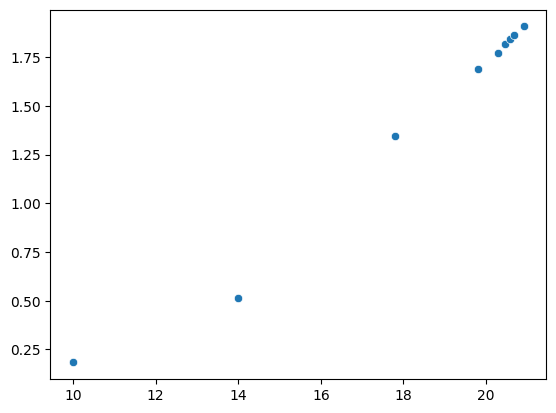

In [43]:
log_kmer_numbers = np.log2(kmer_numbers)
sns.scatterplot(x=log_kmer_numbers, y=specificities)
slope = {}
slope[k_list[0]] = specificities[0]/log_kmer_numbers[0]
for i in range(1,len(specificities)):
    slope[k_list[i]] = (specificities[i]-specificities[i-1])/(log_kmer_numbers[i]-log_kmer_numbers[i-1])

print(slope)

best = max(slope, key=slope.get)
print(best)